In [24]:
from parcels import (FieldSet, AdvectionRK4, BrownianMotion2D, plotTrajectoriesFile, Field,
                     ParticleSet, JITParticle, Variable, ErrorCode)
import numpy as np
import scipy as sc
import math
from datetime import timedelta, datetime
from operator import attrgetter
import copy_plottrajectoriesfile as cpt
import matplotlib.animation as animation
import imageio #to make .gif out of multiple .png
import matplotlib.pyplot as plt
import scipy.io as sio #to load matlab file
import xarray as xr
"""
Load IMOS raw data
"""
#filenames = "../raw_imos_current_data/IMOS_OceanCurrent_HV_2019_C-20190520T232835Z.nc"
filenames = "../raw_imos_current_data/IMOS_OceanCurrent_HV_2018.nc"
dataset=xr.open_dataset(filenames)


"""
Create fieldset with imos raw data
"""

variables = {'U' : 'UCUR',
                'V' : 'VCUR'}
dimensions = {'lat' : 'LATITUDE',
                  'lon' : 'LONGITUDE',
                  'time' : 'TIME'} 

fieldset_imos = FieldSet.from_xarray_dataset(dataset, variables, dimensions, allow_time_extrapolation=True, deferred_load=False)

In [25]:
"""
Change U and V shape 
"""

i_lat_min=list(fieldset_imos.U.lat).index(-36)
i_lat_max=list(fieldset_imos.U.lat).index(-24)+1

i_lon_min=list(fieldset_imos.U.lon).index(150)
i_lon_max=list(fieldset_imos.U.lon).index(160)+1

lati=fieldset_imos.U.lat[i_lat_min:i_lat_max]
longi=fieldset_imos.U.lon[i_lon_min:i_lon_max]
ucur=fieldset_imos.U.data
vcur=fieldset_imos.V.data
u_imos=[]
v_imos=[]
grid_imos=[[],[]]
grid_lat=[]
grid_lon=[]

for i in range(len(lati)): #Create grid of IMOS latitude longitude
    for j in range(len(longi)):
        grid_imos[0].append(lati[i])
        grid_imos[1].append(longi[j]) 
grid_imos=np.asarray(grid_imos).T

for t in range(len(dataset['TIME'])): #for every time step
    values_u=[]
    values_v=[]
    for i in range(i_lat_min,i_lat_max): #take U and V for every couple (lati,longi)
        for j in range(i_lon_min,i_lon_max):
            values_u.append(ucur[t,i,j])
            values_v.append(vcur[t,i,j])
    u_imos.append(np.asarray(values_u))
    v_imos.append(np.asarray(values_v))

"""
Create grid for extrapolated data #(resolution 0.1 degree)
"""
grid_lat_ext,grid_lon_ext = np.mgrid[-36:-24:0.1, 150:160:0.1] 
grid_ext=(grid_lat_ext,grid_lon_ext)

In [26]:
"""
Extrapolate U and V data from grid_imos to grid_exp for each time step
"""

u_ext=[[] for i in range(len(u_imos))]
v_ext=[[] for i in range(len(v_imos))]
for i in range(len(u_imos)):
    u_ext[i] = sc.interpolate.griddata(grid_imos, u_imos[i], grid_ext, method='linear')
    v_ext[i] = sc.interpolate.griddata(grid_imos, v_imos[i], grid_ext, method='linear')
    print("number "+str(i)+" done")

number 0 done
number 1 done
number 2 done
number 3 done
number 4 done
number 5 done
number 6 done
number 7 done
number 8 done
number 9 done
number 10 done
number 11 done
number 12 done
number 13 done
number 14 done
number 15 done
number 16 done
number 17 done
number 18 done
number 19 done
number 20 done
number 21 done
number 22 done
number 23 done
number 24 done
number 25 done
number 26 done
number 27 done
number 28 done
number 29 done
number 30 done
number 31 done
number 32 done
number 33 done
number 34 done
number 35 done
number 36 done
number 37 done
number 38 done
number 39 done
number 40 done
number 41 done
number 42 done
number 43 done
number 44 done
number 45 done
number 46 done
number 47 done
number 48 done
number 49 done
number 50 done
number 51 done
number 52 done
number 53 done
number 54 done
number 55 done
number 56 done
number 57 done
number 58 done
number 59 done
number 60 done
number 61 done
number 62 done
number 63 done
number 64 done
number 65 done
number 66 done
numbe

In [27]:
"""
time_imos float to datetime object
"""
time_imos=np.asarray(dataset['TIME'])

In [28]:
"""
Put extrapolated data in a dataset
"""

import xarray as xr
u=xr.DataArray(u_ext,
                dims=['time','lat','lon'],
                coords={'time':time_imos,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)     

v=xr.DataArray(v_ext,
                dims=['time','lat','lon'],
                coords={'time':time_imos,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)   

ds_ext=u.to_dataset(name='u_cur')
ds_ext['v_cur']=v

In [29]:
"""
Create mask
"""

mask_ocean = 2 * np.ones((ds_ext.dims['lat'], ds_ext.dims['lon'])) * np.isfinite(ds_ext.u_cur.isel(time=0))  
mask_land = 1 * np.ones((ds_ext.dims['lat'], ds_ext.dims['lon'])) * (ds_ext.u_cur.isel(time=0)==0.)
mask_array = mask_land + mask_ocean 
mask_array.plot()

ds_ext.coords['MASK'] = (('lat', 'lon'), mask_array) 
ds_ext['u_cur_masked']=ds_ext['u_cur'].where(ds_ext.MASK==2)
ds_ext['v_cur_masked']=ds_ext['v_cur'].where(ds_ext.MASK==2)

In [30]:
mask_array

<xarray.DataArray 'u_cur' (lat: 120, lon: 100)>
array([[3., 2., 2., ..., 2., 2., 2.],
       [3., 2., 2., ..., 2., 2., 2.],
       [3., 2., 2., ..., 2., 2., 2.],
       ...,
       [3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.]])
Coordinates:
    time     datetime64[ns] 2018-01-01
  * lat      (lat) float64 -36.0 -35.9 -35.8 -35.7 ... -24.4 -24.3 -24.2 -24.1
  * lon      (lon) float64 150.0 150.1 150.2 150.3 ... 159.6 159.7 159.8 159.9

In [31]:
"""
Create wind data
"""

#to replace with real wind data
size3D = (362,120,100)
u_values=-4*np.ones(size3D)
v_values=-4*np.ones(size3D)


u_wind=xr.DataArray(u_values,
                dims=['time','lat','lon'],
                coords={'time':time_imos,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)     

v_wind=xr.DataArray(v_values,
                dims=['time','lat','lon'],
                coords={'time':time_imos,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)   

#add to the existing dataset
ds_ext['u_wind']=u_wind
ds_ext['v_wind']=v_wind

#Mask data on land
ds_ext['u_wind_masked']=ds_ext['u_wind'].where(ds_ext.MASK==2)
ds_ext['v_wind_masked']=ds_ext['v_wind'].where(ds_ext.MASK==2)


"""
Create brownian motion coefficient data
"""

kh_coeff=26.5 #coefficient of oceanic diffusion m^2.sec^-1
values_kh= kh_coeff*np.ones(size3D)

kh_zonal=xr.DataArray(values_kh,
                dims=['time','lat','lon'],
                coords={'time':time_imos,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)     

kh_meridional=xr.DataArray(values_kh,
                dims=['time','lat','lon'],
                coords={'time':time_imos,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)  

#add to the existing dataset
ds_ext['kh_zonal']=kh_zonal
ds_ext['kh_meridional']=kh_meridional

#Mask data on land
ds_ext['kh_zonal']=ds_ext['kh_zonal'].where(ds_ext.MASK==2)
ds_ext['kh_meridional']=ds_ext['kh_meridional'].where(ds_ext.MASK==2)

In [32]:
"""
Create fieldset with extrapolated cur data, wind data, brownian motion
"""

variables = {'U' : 'u_cur_masked', #U refers to U_cur bc AdvectionRK4 needs U
            'V' : 'v_cur_masked',
            'U_wind' : 'u_wind_masked',
            'V_wind' : 'v_wind_masked',
            'Kh_zonal' : 'kh_zonal',
            'Kh_meridional' : 'kh_meridional'}
dimensions = {'lon' : 'lon',
              'lat' : 'lat',
              'time' : 'time'} 

fieldset = FieldSet.from_xarray_dataset(ds_ext, variables, dimensions, allow_time_extrapolation=True)

In [33]:
#fieldset.Kh_zonal.show(land=False)
#ds_ext['kh_zonal']

In [34]:
#ds_ext['u_cur_masked'].to_netcdf('u_extrapolated.nc')
#ds_ext['lon'].to_netcdf('lon_extrapolated.nc')
#ds_ext['lat'].to_netcdf('lat_extrapolated.nc')

In [35]:
from parcels import (FieldSet, AdvectionRK4, BrownianMotion2D, plotTrajectoriesFile, Field,
                     ParticleSet, JITParticle, Variable, ErrorCode)

In [36]:
def LimitBoundaries(lon_i, lat_i, lon_min): #return lon and lat for every lon>lon_min
    newlat=[]
    newlon=[]
    for i in range (0,len(lat_i)):
        if (lon_i[i]>lon_min):
            newlat.append(lat_i[i])
            newlon.append(lon_i[i])
    return newlon, newlat



"""Load & read Matlab file
mat_boundaries = sio.loadmat('../../nsw_boundaries/raw_nsw_boundaries/NSW_boundary.mat')
lat_nsw=mat_boundaries['lat_nsw'][0]
lon_nsw=mat_boundaries['lon_nsw'][0]
lon_nsw, lat_nsw = LimitBoundaries(lon_nsw, lat_nsw, 149.5)
"""
#plt.plot(lon_nsw, lat_nsw)
#plt.show()

"Load & read Matlab file\nmat_boundaries = sio.loadmat('../../nsw_boundaries/raw_nsw_boundaries/NSW_boundary.mat')\nlat_nsw=mat_boundaries['lat_nsw'][0]\nlon_nsw=mat_boundaries['lon_nsw'][0]\nlon_nsw, lat_nsw = LimitBoundaries(lon_nsw, lat_nsw, 149.5)\n"

In [37]:
"""
Compare before and after data extrapolation
"""

#fieldset_imos.U.show(domain={'N':-24, 'S':-36, 'E':160, 'W':150},land=False)
#fieldset.U.show(land=False)

def cart2pol(x, y):
    """
    author : Dr. Schaeffer
    return rho in m/s and phi in radian in oceano conv
    """
    
    rho = math.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [38]:
import math #bc kernel cant handle numpy
def WindDrag(particle, fieldset, time):

    #constants
    S_x = 1.12e-4 #m^2 (from Daniel Lee)
    S_y = 5.5e-4 #m^2 (from Daniel Lee)
    S_w = 3.78e-4 #m^2 (from Daniel Lee)
    rho_a = 1.225 #kg.m^-3
    rho_w = 1030 #kg.m^-3
    
    #variables
    C_ax = 0.1
    C_ay = 1
    C_w = 1
    gamma = 40*math.pi/180
    
    
    u_wind = fieldset.U_wind[time, particle.depth, particle.lat, particle.lon]
    v_wind = fieldset.V_wind[time, particle.depth, particle.lat, particle.lon]

    coeff = (math.sqrt((S_x*C_ax)**2+ (S_y*C_ay)**2))/(S_w*C_w)
    vel_wind = math.sqrt((u_wind)**2 + (v_wind)**2)
    dir_wind = math.atan2(u_wind,v_wind) 
    vel_bb = math.fabs(vel_wind)*math.sqrt(rho_a/rho_w*coeff)
    
    theta = dir_wind + gamma #wind_dir in oceano, gamma : angle between wind course and BB course
    
    diff_x += (math.sin(theta)*vel_bb)*particle.dt #in meters
    diff_y += (math.cos(theta)*vel_bb)*particle.dt #in meters
    
    particle.lon += diff_x/111e3 #in deg
    particle.lat += diff_y/111e3 #in deg

In [39]:
#fieldset.U_wind.show(show_time=10*86400, land=False)

In [40]:
"""
Dataset for a time fixed to plot trajectories with U field
"""
ds_ext.isel(time=0).to_netcdf('dataset.nc')

In [45]:
%matplotlib qt
import math

def DeleteParticle(particle, fieldset, time):
    particle.delete()

seed = sio.loadmat('polygons_files/seeds.mat')
seed_lons = seed['seedlon'][0]
seed_lats = seed['seedlat'][0]

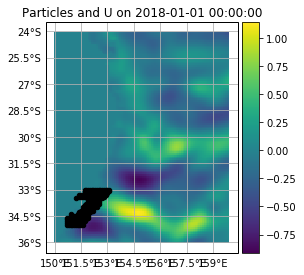

In [59]:
pset = ParticleSet.from_list(fieldset=fieldset,
                             lon=seed_lons,
                             lat=seed_lats,
                             time = time_imos[0],
                             repeatdt=timedelta(days=1),
                             pclass = JITParticle)

images=[]
%matplotlib inline
pset.show(field=fieldset.U,land=False)

In [54]:
#print(pset)
kernels=pset.Kernel(WindDrag)+pset.Kernel(BrownianMotion2D)+pset.Kernel(AdvectionRK4)
pset.execute(kernels, 
             runtime=timedelta(days=30), 
             dt=timedelta(hours=1), #toutes les heures
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=pset.ParticleFile(name="nc_trajectory_files/trajectory.nc", outputdt=timedelta(days=1)))
#pset.show(field=fieldset.U,land=False)
#print(pset)

INFO: Compiled JITParticleWindDragBrownianMotion2DAdvectionRK4 ==> /tmp/parcels-13529592/a665d50c131df614960b96f59ab3b845.so
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:01:09 Time:  0:01:09


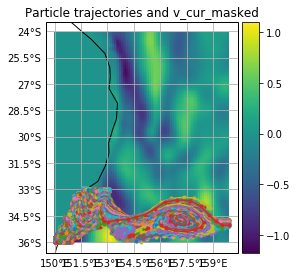

In [58]:
%matplotlib inline
plotTrajectoriesFile('nc_trajectory_files/trajectory.nc',
                     tracerfile='dataset.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='v_cur_masked');

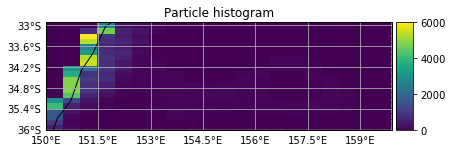

<module 'matplotlib.pyplot' from '/home/z3529592/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [60]:
plotTrajectoriesFile('nc_trajectory_files/trajectory.nc', mode='hist2d')